### Import necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./tweets_sent_new_df.csv', parse_dates=['datetime_new'], index_col='ids')

In [3]:
df.describe()

,score
count,715978.000000
mean,0.906193
std,3.164574
min,-104.000000
25%,-2.000000
50%,1.000000
75%,3.000000
max,32.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715978 entries, nan to 2072532046.0
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype                    
---  ------        --------------   -----                    
 0   datetime_new  715978 non-null  datetime64[ns, UTC+01:00]
 1   score         715978 non-null  int64                    
 2   sentiment     715978 non-null  object                   
dtypes: datetime64[ns, UTC+01:00](1), int64(1), object(1)
memory usage: 21.8+ MB


#### Check the values of the sentiment column

In [5]:
df.sentiment.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

#### Only the sentiment column will be used after converting it to numerical values, and score can be discarded

In [7]:
df = df.sort_values(by='datetime_new')
df = df.drop(['score'], axis=1)
df.sentiment = df.sentiment.replace({'positive': 1, 'negative': -1, 'neutral':0})

In [8]:
df.head()

,datetime_new,sentiment
ids,,
1.467811e+09,2009-04-06 22:19:49+01:00,-1
1.467811e+09,2009-04-06 22:19:53+01:00,1
1.467811e+09,2009-04-06 22:19:57+01:00,-1
1.467811e+09,2009-04-06 22:19:57+01:00,-1
1.467812e+09,2009-04-06 22:20:03+01:00,-1


#### Check the first and last dates where there are tweets

In [9]:
print('Min date: %s' % df['datetime_new'].min().date())
print('Max date: %s' % df['datetime_new'].max().date())

Min date: 2009-04-06
Max date: 2009-06-25


#### Sentiment for all tweets will be aggregated daily for the dates where there are tweets

In [10]:
daily_series = df.groupby(df['datetime_new'].dt.date)['sentiment'].sum()
daily_series.head(10)

datetime_new
2009-04-06     331
2009-04-07    2233
2009-04-17     512
2009-04-18    3413
2009-04-19    4222
2009-04-20    2550
2009-04-21    1210
2009-05-01    1082
2009-05-02    3933
2009-05-03    4933
Name: sentiment, dtype: int64

#### Check the span of the entire period between the first and last dates where there are tweets

In [11]:
daily_series.index.max() - daily_series.index.min()

datetime.timedelta(days=80)

#### Create entries for the dates where there are NO tweets and set their aggregate sentiment value to NaN

In [12]:
idx = pd.date_range(daily_series.index.min(), daily_series.index.max())
idx

DatetimeIndex(['2009-04-06', '2009-04-07', '2009-04-08', '2009-04-09',
               '2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13',
               '2009-04-14', '2009-04-15', '2009-04-16', '2009-04-17',
               '2009-04-18', '2009-04-19', '2009-04-20', '2009-04-21',
               '2009-04-22', '2009-04-23', '2009-04-24', '2009-04-25',
               '2009-04-26', '2009-04-27', '2009-04-28', '2009-04-29',
               '2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03',
               '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07',
               '2009-05-08', '2009-05-09', '2009-05-10', '2009-05-11',
               '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15',
               '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19',
               '2009-05-20', '2009-05-21', '2009-05-22', '2009-05-23',
               '2009-05-24', '2009-05-25', '2009-05-26', '2009-05-27',
               '2009-05-28', '2009-05-29', '2009-05-30', '2009-05-31',
      

In [13]:
daily_series = daily_series.reindex(idx)
print(daily_series)

2009-04-06     331.0
2009-04-07    2233.0
2009-04-08       NaN
2009-04-09       NaN
2009-04-10       NaN
               ...  
2009-06-21    -824.0
2009-06-22    -831.0
2009-06-23   -1010.0
2009-06-24    -412.0
2009-06-25   -1278.0
Freq: D, Name: sentiment, Length: 81, dtype: float64


#### Plotting the daily aggregates would help to indenify the overall trend

<Axes: title={'center': 'Overall Daily Sentiment'}>

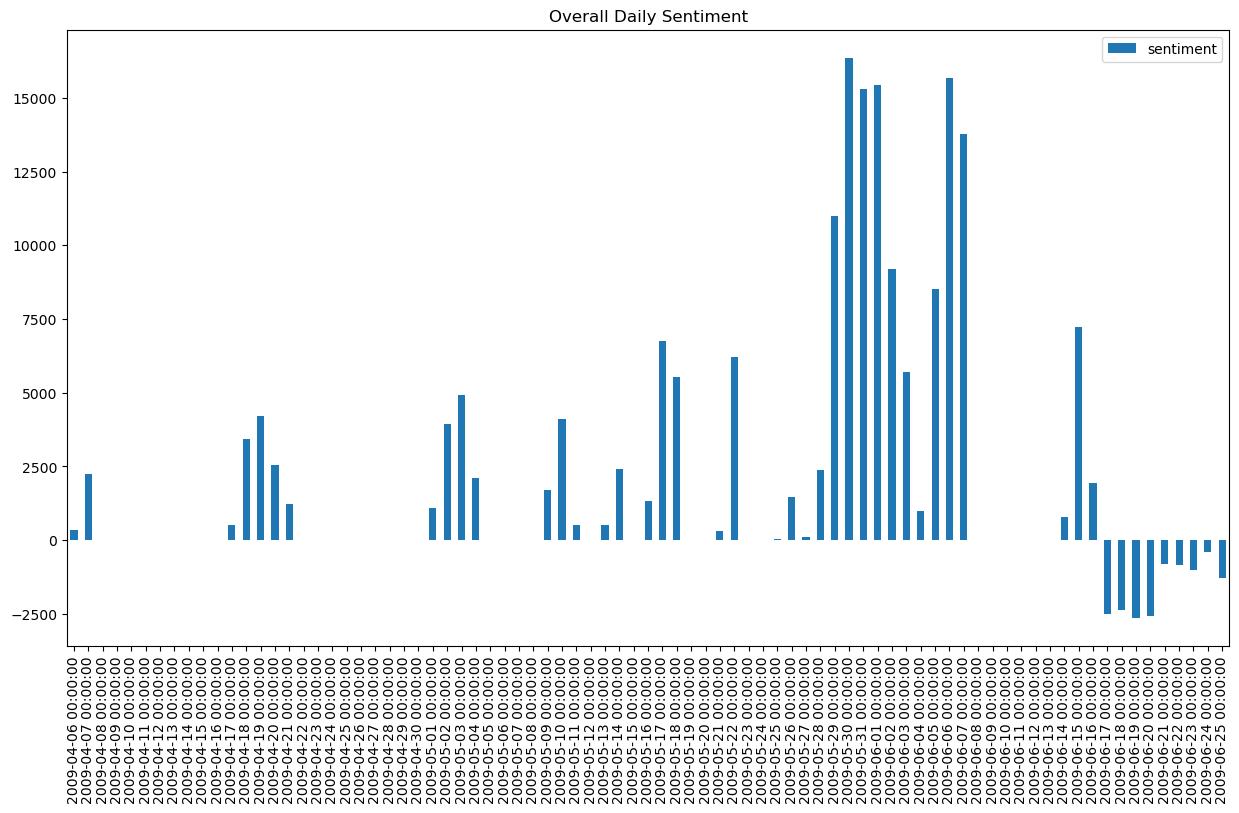

In [14]:
daily_series.plot.bar(figsize = (15, 8), title='Overall Daily Sentiment', legend=True)

#### Explore if aggregating every 4 Hours for instance would show significant change in the trends

In [15]:
hourly_df = df.groupby(pd.Grouper(key='datetime_new', freq='4h')).sum() 
hourly_df.head()

,sentiment
datetime_new,
2009-04-06 20:00:00+01:00,331
2009-04-07 00:00:00+01:00,1059
2009-04-07 04:00:00+01:00,996
2009-04-07 08:00:00+01:00,178
2009-04-07 12:00:00+01:00,0


<Axes: title={'center': 'Sentiment Aggregates every 4 Hours'}, xlabel='datetime_new'>

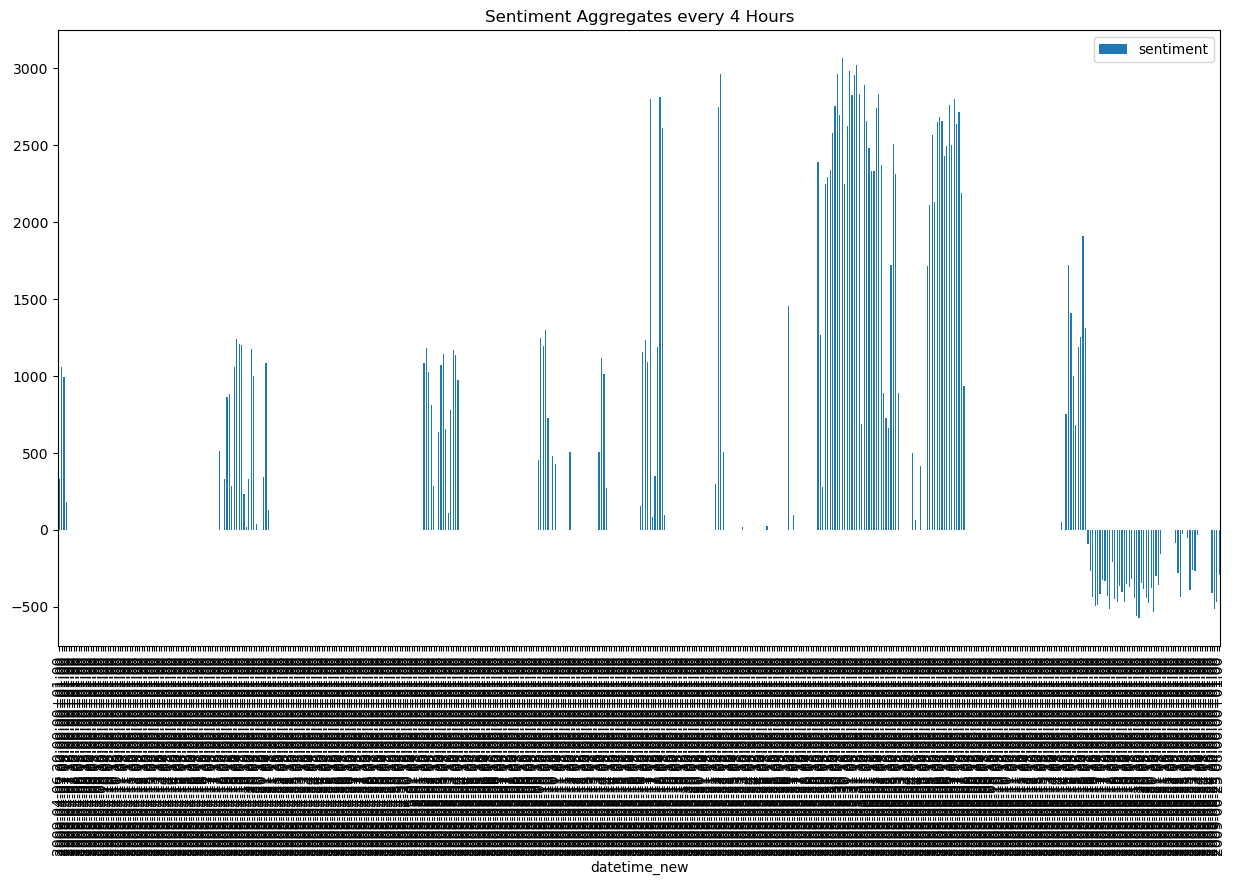

In [16]:
hourly_df.plot.bar(figsize = (15, 8),title='Sentiment Aggregates every 4 Hours', legend=True)

### It looks like hourly aggregates have little significance over daily ones. So daily will be used for further analysis.